In [1]:
import pytraj as pt
import numpy as np
import pandas as pd
import nglview as ngv
import ggplot
from ggplot import *
import sys

In [2]:
#Some useful functions to do vector math based on center of mass of selection masks

#compute vector norms or normalize a trajectory containing a set of coordinates
#if there is only 1 point in each frame then the this will only be an n_frame by 3 array
#otherwise it will be an n_frame by n_vectors by 3 array
def trajVectors_norms(trajVectors):
    if len(trajVectors.shape)==3:
        norms=np.sqrt(trajVectors[:,:,0]**2+trajVectors[:,:,1]**2+trajVectors[:,:,2]**2)
        return norms
    elif len(trajVectors.shape)==2:
        norms=np.sqrt(trajVectors[:,0]**2+trajVectors[:,1]**2+trajVectors[:,2]**2)
        return norms
    elif len(trajVectors.shape)==1:
        norms=np.sqrt(sum(trajVectors**2))
        return norms
    else:
        print "ERROR! trajVectors is empty or not an np.array!!!"
        return

def normalize_trajVectors(trajVectors):
    if len(trajVectors.shape)==3:
        norms=trajVectors_norms(trajVectors)
        return(np.array([trajVectors[:,:,0].T/norms.T,trajVectors[:,:,1].T/norms.T,trajVectors[:,:,2].T/norms.T]).T)
    elif len(trajVectors.shape)==2:
        norms=trajVectors_norms(trajVectors)
        return(np.array([trajVectors[:,0].T/norms.T,trajVectors[:,1].T/norms.T,trajVectors[:,2].T/norms.T]).T)
    elif len(trajVectors.shape)==1:
        norms=trajVectors_norms(trajVectors)
        return trajVectors/norms
    else:
        print "ERROR! trajVectors is empty or not an np.array!!!"
        return
        
#Be aware that trajectories are 3D arrays of shape: n_frames by n_atoms by 3
#but the return values here will be 2D arrays of shape: n_frames by 3 (for COM and COM_dirVec)
#and 1D array of length: n_frames (for COM_angle ... and COM_dihedral if I make that)

#returns the center of mass of a given mask over traj
def traj_mask_com(traj,mask):
    mInds=pt.select_atoms(mask=mask,topology=traj.top)
    if (len(mInds) <= 0):
        print "ERROR: mask does not correspond to any atoms!"
        return
    maskXYZ=traj.xyz[:,mInds,:]
    ii=0
    for iatm in np.arange(maskXYZ.shape[1]):
        if ii==0:
            trajCOM=maskXYZ[:,iatm,:]
        else:
            trajCOM=trajCOM+maskXYZ[:,iatm,:]
        ii=ii+1
    trajCOM=trajCOM/ii
    trajCOM.reshape(traj.n_frames,1,3)
    return trajCOM

#caclulates the direction vector pointing from mask1 to mask2
def traj_maskSet_COM_dirVec(traj,mask1,mask2):
    trajCOM1=traj_mask_com(traj,mask1)
    trajCOM2=traj_mask_com(traj,mask2)
    return trajCOM2-trajCOM1

#calculates the angle between mask1,mask2,mask3 (e.g. mask2 is the corner of the angle)
def traj_maskSet_COM_angle(traj,mask1,mask2,mask3):
    trajCOM1=traj_mask_com(traj,mask1)
    trajCOM2=traj_mask_com(traj,mask2)
    trajCOM3=traj_mask_com(traj,mask3)
    v1=normalize_trajVectors(trajCOM1-trajCOM2)
    v2=normalize_trajVectors(trajCOM3-trajCOM2)
    dotP=v1[:,0]*v2[:,0]+v1[:,1]*v2[:,1]+v1[:,2]*v2[:,2]
    return np.arccos(dotP)*180/np.pi
    
def traj_maskSet_COM_dirVec_zPHI(traj,mask1,mask2,useRadians=False):
    traj_dir_vecs=traj_maskSet_COM_dirVec(traj,mask1,mask2)
    traj_dir_nvecs=normalize_trajVectors(traj_dir_vecs)
    if len(traj_dir_vecs.shape)>1:
        zPHI=np.arccos(traj_dir_nvecs[:,2])
        if useRadians:
            return zPHI
        else:
            return zPHI*180/np.pi
    elif len(trajVectors.shape)==1:
        zPHI=np.arccos(traj_dir_nvecs[2])
        if useRadians:
            return zPHI
        else:
            return zPHI*180/np.pi
    else:
        print "ERROR! trajVectors is empty or not an np.array!!!"
        return
    

In [3]:
basePath="/home/dkent/resv"
systems=["resv-membr-323.15k","resv-membr-310k"]
topFileName="step5_assembly.psf"#"step2_solvator.psf"
trajFileNameEXT="_production.dcd"
trajLists=[["step7","step8","step9","step10","step11","step12","step13"],\
          ["step7.1","step7.2","step7.3","step7.4","step7.5","step7.6"]]
TAK_IDS=np.arange(1,19)
#trajFilePath=strucPathBase+"/"+trajFileName
#iterTraj=pt.iterload(trajFilePath,topFilePath)
#iterTraj

In [4]:
mask2_ext='@O15,O16'
mask1_ext='@O17'
membMask=":DPPC"
output_frequency=.002
angleDataSet=[]
trajChunkSize=5000
for isys in np.arange(len(systems)):
    system=systems[isys]
    print "Working on system "+system
    trajList=trajLists[isys]
    systemPath=basePath+"/"+system
    topFilePath=systemPath+"/"+topFileName
    trajFilePath=systemPath+"/namd"
    trajFileList=[]
    print "-Topology File Path = "+topFilePath
    print "-building trajectory filepath list",
    for runFile in trajList:
        trajFileList.append(trajFilePath+"/"+runFile+trajFileNameEXT)
    print trajFileList
    print "-loading trajectories"
    iterTraj=pt.iterload(trajFileList,topFilePath)
    print iterTraj
    trajChunkCount=iterTraj.n_frames/trajChunkSize
    print "--Trajectory has "+str(iterTraj.n_frames)+" frames"
    print "--Chunk size set to "+str(trajChunkSize)+" frames"
    print "--Trajectory will be processed in "+str(trajChunkCount)+" chunks"
    for iChunk in np.arange(trajChunkCount+1):
        chunkStart=iChunk*trajChunkSize
        if (chunkStart < (iterTraj.n_frames)-1):
            chunkEnd=(iChunk+1)*trajChunkSize
            if (chunkEnd >= iterTraj.n_frames):
                chunkEnd = iterTraj.n_frames-1
            print "---working on chunk "+str(iChunk)+" (frames "+str(chunkStart)+" to "+str(chunkEnd)+")"
            print "----Loading trajectory to memory"
            sys.stdout.flush()
            trajChunk=iterTraj[chunkStart:chunkEnd]
            print "----autoimaging"
            sys.stdout.flush()
            trajChunk.autoimage()
            print "----computing membrane center"
            sys.stdout.flush()
            MEMB_COM=traj_mask_com(trajChunk,membMask)
            print "----working on TAK residue: ",
            sys.stdout.flush()
            for TAKID in TAK_IDS:
                print " "+str(TAKID),
                sys.stdout.flush()
                mask1=":"+str(TAKID)+mask1_ext
                mask2=":"+str(TAKID)+mask2_ext
                #print ' masks are: '+mask1+' to '+mask2
                TAK_Zangles=traj_maskSet_COM_dirVec_zPHI(trajChunk,mask1,mask2,useRadians=False)
                TAK_COM=traj_mask_com(trajChunk,":"+str(TAKID))
                tempData=pd.DataFrame()
                tempData['SYSTEM']=[system]*len(TAK_Zangles)
                tempData['TAKID']=[TAKID]*len(TAK_Zangles)
                tempData['FRAME']=np.arange(len(TAK_Zangles))+chunkStart
                tempData['TIME']=(np.arange(len(TAK_Zangles))+chunkStart)*output_frequency
                tempData['ZAngle']=TAK_Zangles
                tempData['TAK_CENTER_Z']=TAK_COM[:,2]
                tempData['MEMB_CENTER_Z']=MEMB_COM[:,2]
                tempData['TAK_DeltaZ']=TAK_COM[:,2]-MEMB_COM[:,2]
                angleDataSet.append(tempData)
            print ""
    print "-------"

print "writting TAK data to data file"
angleData=pd.concat(angleDataSet)
angleData.to_csv("TAK_data.ext.dat",index=False,sep=" ")
print "done!"

Working on system resv-membr-323.15k
-Topology File Path = /home/dkent/resv/resv-membr-323.15k/step5_assembly.psf
-building trajectory filepath list ['/home/dkent/resv/resv-membr-323.15k/namd/step7_production.dcd', '/home/dkent/resv/resv-membr-323.15k/namd/step8_production.dcd', '/home/dkent/resv/resv-membr-323.15k/namd/step9_production.dcd', '/home/dkent/resv/resv-membr-323.15k/namd/step10_production.dcd', '/home/dkent/resv/resv-membr-323.15k/namd/step11_production.dcd', '/home/dkent/resv/resv-membr-323.15k/namd/step12_production.dcd', '/home/dkent/resv/resv-membr-323.15k/namd/step13_production.dcd']
-loading trajectories
pytraj.TrajectoryIterator, 53905 frames: 
Size: 48.000000 (GB)
<Topology: 40522 atoms, 6578 residues, 6578 mols, non-PBC>
           
--Trajectory has 53905 frames
--Chunk size set to 5000 frames
--Trajectory will be processed in 10 chunks
---working on chunk 0 (frames 0 to 5000)
----Loading trajectory to memory
----autoimaging
----computing membrane center
----worki

In [5]:
angleData.to_csv("TAK_data.ext.dat",index=False,sep=" ")

/cm/shared/apps/miniconda/lib/python2.7/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


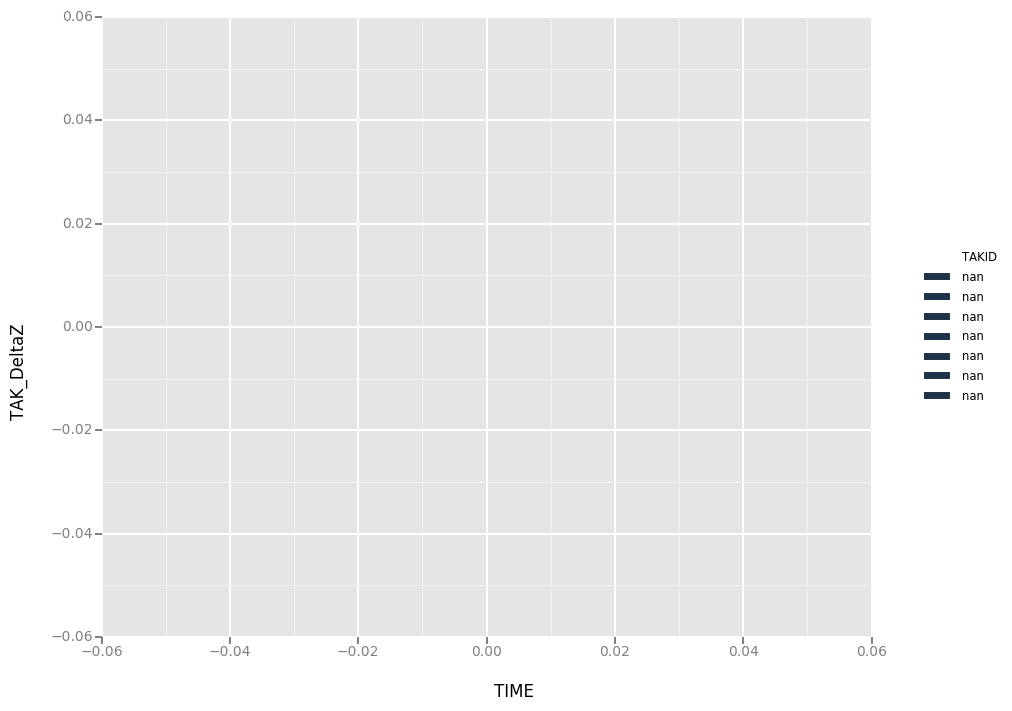

<ggplot: (2932923995621)>

In [7]:
ggplot(aes(x='TIME',y='TAK_DeltaZ',color='TAKID'),data=angleData[angleData['SYSTEM']==system[0]])+geom_line()
ggplot(aes(x='TIME',y='TAK_DeltaZ',color='TAKID'),data=angleData[angleData['SYSTEM']==system[1]])+geom_line()

In [9]:
testTop="/home/dkent/resv/resv-membr-310k/step5_assembly.psf"
testTrajFile3="/home/dkent/resv/resv-membr-310k/namd/step7.3_production.dcd"
testTrajFile2="/home/dkent/resv/resv-membr-310k/namd/step7.2_production.dcd"
testTrajFile4="/home/dkent/resv/resv-membr-310k/namd/step7.4_production.dcd"
testTrajFile5="/home/dkent/resv/resv-membr-310k/namd/step7.5_production.dcd"
testTrajFile6="/home/dkent/resv/resv-membr-310k/namd/step7.6_production.dcd"
testTraj3=pt.iterload(testTrajFile3,testTop)
testTraj2=pt.iterload(testTrajFile2,testTop)
testTraj4=pt.iterload(testTrajFile4,testTop)
testTraj5=pt.iterload(testTrajFile5,testTop)
testTraj6=pt.iterload(testTrajFile6,testTop)
print testTraj2
print testTraj3
print testTraj4
print testTraj5
print testTraj6

pytraj.TrajectoryIterator, 4665 frames: 
Size: 4.000000 (GB)
<Topology: 40522 atoms, 6578 residues, 6578 mols, non-PBC>
           
pytraj.TrajectoryIterator, 10000 frames: 
Size: 9.000000 (GB)
<Topology: 40522 atoms, 6578 residues, 6578 mols, non-PBC>
           
pytraj.TrajectoryIterator, 7745 frames: 
Size: 7.000000 (GB)
<Topology: 40522 atoms, 6578 residues, 6578 mols, non-PBC>
           
pytraj.TrajectoryIterator, 7858 frames: 
Size: 7.000000 (GB)
<Topology: 40522 atoms, 6578 residues, 6578 mols, non-PBC>
           
pytraj.TrajectoryIterator, 7984 frames: 
Size: 7.000000 (GB)
<Topology: 40522 atoms, 6578 residues, 6578 mols, non-PBC>
           
